# Main Test Model
This code its the most recent and just has the necessary code to work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import sys
from itertools import product
from lib.TechnicalIndicators import *

In [2]:
class MaintenanceMarginTables():
    #obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    
    def __init__(self):
        ### Available Maintenance Margin tables ###
        self.BTCUSDT = None
        self.BTCBUSD = None
        ########### Fill each table ##############
        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 10000000, 20000000, 50000000, 100000000, 200000000, 300000000, 500000000], #Position Bracker (Notional Value in USDT) (top boundary)
         'ML' : [125, 100, 50, 20, 10, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 266300, 1266300, 2516300, 5016300, 25016300, 100016300] #Maintenance AMount (USDT)
        }
        self.BTCUSDT = pd.DataFrame(data = d)

        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 7500000, 40000000, 100000000, 200000000, 400000000, 600000000, 1000000000], #Position Bracker (Notional Value in BUSD) (top boundary)
         'ML' : [50, 25, 20, 10, 6, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 203800, 2203800, 4703800, 9703800, 49703800, 199703800] #Maintenance AMount (BUSD)
        }
        self.BTCBUSD = pd.DataFrame(data = d)
        
    def get_table(self, pair):
        table = "self."+ pair.upper()
        return eval(table)
MMT = MaintenanceMarginTables()        

In [3]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, symbol, order_type = "MARKET", verbose = True):
        self.verbose = verbose
        self.symbol = symbol
        self.order_type = order_type
        self.amount = amount
        self.leverage = leverage
        self.amount_to_spend = self.amount/self.leverage #amount to really spend from my balance
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        ########### Open position params ###########
        self.entry_price = None
        self.opening_at = None #opening position datetime
        self.unlev_amount_to_buy_units = None
        self.amount_to_buy_units = None
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.unlev_units = None
        self.units = None
        ########### Close position params ###########
        self.closing_at = None #close position datetime
        self.closing_fee_as_amount = None 
        self.closing_fee_as_units = None
        self.closing_price = None
        self.liquidated = False #Tells if position was liquidated
        self.liquidation_price = None
        
    def open_position(self, date, entry_price):
        self.opening_at = date # open position datetime
        if entry_price is None: 
            self.entry_price = self.expected_entry_price #for limit orders
        else:
            self.entry_price = entry_price #market orders    
        ##################### Works for long and short ##################    
        self.unlev_amount_to_buy_units = self.amount_to_spend/( 1 + self.leverage*self.fee_taker*self.use_fee )
        self.amount_to_buy_units = self.unlev_amount_to_buy_units*self.leverage
        self.opening_fee_as_amount = self.amount_to_buy_units*self.fee_taker*self.use_fee
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        self.unlev_units = self.unlev_amount_to_buy_units/self.entry_price
        self.units = self.unlev_units*self.leverage
        if self.position == 1 and self.verbose:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        elif self.verbose:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        return self.units, self.opening_fee_as_amount
        
    def get_close_fee(self, price, as_amount= True):
        #long - pay more comission if price raises
        #short - pay more comission if price falls
        fee = self.units * self.entry_price + self.position * self.units * (price - self.entry_price) 
        fee = fee * self.fee_taker
        if not as_amount: fee/=price #as units
        return fee * self.use_fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True):
        #get profit (by default doesnt include fee as Binance)
        PnL = self.position * self.units * (price - self.entry_price)
        fee = self.get_close_fee(price, as_amount= True) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_position_value(self, price, include_fee = True, as_amount = True):
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True)
        pos_val = self.unlev_amount_to_buy_units + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price, liquidate = False):
        self.closing_at = date
        self.closing_price = price
        self.closing_fee_as_amount = self.get_close_fee(price, as_amount = True)
        self.closing_fee_as_units = self.get_close_fee(price, as_amount = False)
        pos_value = self.get_position_value(price)
        if self.position == -1 and self.verbose:
            print("{} |  Buying (closing) {} for {}".format(date, self.units, round(price, 5)))
        elif self.verbose:
            print("{} |  Selling (closing) {} for {}".format(date, self.units, round(price, 5)))  
        return pos_value
    
    def is_open(self):
        return self.closing_at is None
    
    def is_closed(self):
        return not self.is_open()
    
    def get_maintenance_margin(self, price):
        #this is an example of how to retrieve a table and the necessary row with the information.
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        size = self.units*price #size of position
        #locate the corresponding row with size
        row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
        #get all the row values, these are the required to calculate maintenance margin.
        tier, pb, ml, mmr, ma = row.values[0]
        mm = size * mmr - ma
        return mm
    
    def calculate_margin_ratio(self, price):
        #when margin ratio == 1, that is the liquidation price
        maintenance_margin = self.get_maintenance_margin(price)
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        mark_price = price #for simplicity
        entry_price = self.entry_price
        
        margin_ratio = maintenance_margin/( balance + self.position* quantity * ( mark_price - entry_price ))
        return margin_ratio
    
    def get_liquidation_price(self):
        #uses price instead of mark_price for simplicity
        #the liquidation price changes to farther when mark price gets close, so we  
        #execute this function many times to get close to the real one!!!!
        if self.liquidation_price is not None: return self.liquidation_price
        mark_price = self.entry_price
        pos = self.position
        entry_price = self.entry_price
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        precision = 5 #more precision == closer you get to real liquidation price
        for i in range(precision):
            maintenance_margin = self.get_maintenance_margin(mark_price)
            liquidation_price = pos*( maintenance_margin - balance )/quantity + entry_price
            mark_price = liquidation_price
        self.liquidation_price = liquidation_price 
        return self.liquidation_price
    
    def should_liquidate(self, price): 
        if self.position == 1 and price <= self.get_liquidation_price():
            return True
        elif self.position == -1 and price >= self.get_liquidation_price():
            return True
        else:
            return False
    
    def liquidate_position(self, date):
        self.closing_at = date
        self.closing_price = self.liquidation_price
        self.liquidated = True
        if self.position == -1 and self.verbose:
            print("{} |  Buying (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5)))
        elif self.verbose:
            print("{} |  Selling (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5))) 

In [28]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0,
                 verbose = True, csv = "data/5m.csv"):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.csv = csv #csv to use
        self.initial_balance = amount
        self.available_balance = amount #keeps unlevered balance (real balance)
        self.open_orders = [] #stores open orders
        self.closed_orders= [] #stores closed orders
        self.PnLs = []
        self.liquidated_orders = 0 #stores count of liquidated orders
        self.trades = 0
        self.paid_fees = 0 #accumulates paid fees
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()
        self.verbose = verbose
    def get_data(self):
        raw = pd.read_csv(self.csv, parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "Close"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        close = round(self.data.Close.iloc[bar], 5)
        return date, close
    
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open long position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = 1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
              verbose = self.verbose)
            if order.amount_to_spend > self.available_balance+0.1: #avoids floating errors
                self.not_enough_balance(order.amount_to_spend, self.available_balance)
                return #dont continue with operation!
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [-1]: #closing short position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            self.PnLs.append(order.get_PnL(price = price, include_fee = True) - order.opening_fee_as_amount)
                    
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open short position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
              verbose = self.verbose)
            if order.amount_to_spend > self.available_balance+0.1: #avoids floating errors
                self.not_enough_balance(order.amount_to_spend, self.available_balance)
                return #dont continue with operation!
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [1]: #closing long position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            self.PnLs.append(order.get_PnL(price = price, include_fee = True) - order.opening_fee_as_amount)
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        order = self.open_orders[0]
        pos_value = order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position
    
    def verify_not_liquidation(self, bar):
        date, price = self.get_values(bar)
        if self.get_position() == 0: return #currently no open positions
        order = self.open_orders[0]
        if order.should_liquidate(price):
            order.liquidate_position(date = date)
            self.open_orders = []
            self.closed_orders.append(order)
            self.liquidated_orders += 1
    def not_enough_balance(self,need, have):
        print("You dont have necessary balance to open this order!: cost:{}, balance:{}".format(
                    round(need,2), round(have,2)
                ))
    def get_max_order_leverage(self, total_amount):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
        return max_leverage
    def get_max_order_amount(self, leverage):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_total_amount = table.loc[ leverage <= table['ML']].PB.iloc[-1]
        return max_total_amount
    def validate_order_amount(self, desired_amount, leverage):
        #returns a valid amount to spend with a certain leverage
        max_amount_with_lev = self.get_max_order_amount(leverage)
        max_amount_with_balance = self.available_balance*self.leverage
        amount = min(max_amount_with_lev, max_amount_with_balance, desired_amount) #respect leverage and balance restrictions!!
        if self.verbose and desired_amount != amount: print("Invalid amount for order, changing to a valid one...")
        return amount
    def change_leverage(self, new_leverage):
        current_position = self.get_position()
        if current_position: 
            print("cant change leverage with open position")
            return -1
        self.leverage = new_leverage
        return self.leverage

In [37]:
class IterativeBacktest(BinanceApi):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.strategies = [] #keeps all the strategies used
        self.predicted_pos = 0 #keeps current predicted position of strategies
        self.ind_sum = 0 #keeps current indicators sum for predicted positions
        self.weights_sum = 0 #keeps weight sum of strategies to use it with leverage

    # helper method
    def go_long(self, bar, units = None, amount = None, prc = False):
        if self.get_position() != 0:
            self.go_neutral(bar) #if some position, go neutral first
        if self.should_end_session(): return
        self.leverage_strategy(ind_sum = self.ind_sum, ind_count = len(self.strategies))
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            if prc: 
                amount = (self.available_balance * amount/100) * self.leverage    
            amount = self.validate_order_amount(amount, self.leverage)
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None, prc = False):
        if self.get_position() != 0:
            self.go_neutral(bar) # if some position, go neutral first
        if self.should_end_session(): return
        self.leverage_strategy(ind_sum = self.ind_sum, ind_count = len(self.strategies))
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance*0.95 * self.leverage
            if prc: 
                amount = (self.available_balance * amount/100) * self.leverage      
            amount = self.validate_order_amount(amount, self.leverage)
            self.sell_instrument(bar, amount = amount) # go short
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.sell_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() == -1: #if short, buy all
            self.buy_instrument(bar, units = self.open_orders[0].units)
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [0]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        good_trades = 0
        bad_trades = 0
        good_trades_prc = 0
        bad_trades_prc = 0
        if self.trades > 0 :
            good_trades = np.sum(np.array(self.PnLs) > 0, axis = 0)
            good_trades_prc = round(good_trades / self.trades *100,1)
            bad_trades = np.sum(np.array(bc.PnLs) <= 0, axis = 0)
            bad_trades_prc = round(bad_trades / self.trades *100,1)
            
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("{} | +++ CLOSING FINAL POSITION +++".format(date))
            print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
            print("{} | number of trades executed = {}".format(date, self.trades)) 
            print("{} | number of liquidated orders = {}".format(date, self.liquidated_orders))
            print("{} | number of good trades = {} ({}%)".format(date, good_trades, good_trades_prc))
            print("{} | number of bad trades = {} ({}%)".format(date, bad_trades, bad_trades_prc))
            print("{} | Amount spent on fee = {} ({}% of initial balance)".format(
            date, self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")    
    
    def should_end_session(self):
        return self.available_balance < 0.1 and self.get_position() == 0 #no money and no positions
        
    def optimize_parameters(self, number_of_tests = 4):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        test_weights = np.random.random_sample(size = (number_of_tests, 7))
        
        # test all combinations
        results = []
        for weights in test_weights:
            results.append(self.test_strategy(
                keep_metrics = False, #False makes the process faster
                verbose = False, #dont print order stuff
                weights = weights
            ))
        
        best_perf = np.max(results) # best performance
        opt_weights = test_weights[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_strategy(
                keep_metrics = True, #False makes the process faster
                verbose = True, #dont print order stuff
                weights = opt_weights
            )
                   
        # create a df with many results
        #many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        #many_results["performance"] = results
        #self.results_overview = many_results
                            
        return opt_weights, best_perf   
    
    def test_strategy(self,keep_metrics = True, verbose = True, weights = [1]*7):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        self.PnLs = []
        # prepare params
        #SMA
        SMA_S = 2
        SMA_L = 5
        #EWMA
        approx_avg_period_s = 2
        approx_avg_period_l = 5
        #BBS
        dev = 1.5
        periods = 10
        #prepare strategies
        self.strategies = [
            SMA(
                data = self.data,
                SMA_S = SMA_S,
                SMA_L = SMA_L,
                column = "Close",
                default_strategy = 1,
                weight = weights[0]
            ),
            EWMA(
                data = self.data,
                approx_avg_period_s = approx_avg_period_s,
                approx_avg_period_l = approx_avg_period_l,
                column = "Close",
                default_strategy = 1,
                weight = weights[1]
            ),
            BollingerBands(
                data = self.data,
                dev = dev, 
                periods = periods,
                column = "Close",
                default_strategy = 1,
                weight = weights[2]
            ),
            MACD(
                data = self.data,
                fast =12,
                slow =26, 
                signal = 9,
                column = "Close",
                default_strategy = 1,
                weight = weights[3]
            ),
            RSI(
                data = self.data,
                length = 14,
                column = "Close",
                default_strategy = 1,
                weight = weights[4]
            ),
            Hammer(
                data = self.data,
                default_strategy = 1,
                weight = 1
            ),
            Doji(
                data = self.data,
                default_strategy = 1,
                weight = 1
            )
        ]
        self.calculate_weights_sum()
        for strategy in self.strategies:
            strategy.calculate() #add columns to data 
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
 
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(): break #check if should end session  
            ############### Algorithm ############### 
            self.ind_sum = 0
            for strategy in self.strategies:
                self.ind_sum += strategy.strategy(bar) * strategy.weight
            self.predicted_pos = np.sign(round(self.ind_sum)) #discards weak signals < |0.5|
            if self.predicted_pos == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = 95, prc=True) # go long with full amount
            if self.predicted_pos == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = 95, prc=True) # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 1)
    
    def leverage_strategy(self, ind_sum, ind_count, min_lev = 1, max_lev = 10):
        if max_lev < min_lev:
            print("max leverage is less than min leverage")
            return -1
        #y2 = y1 + m(x2-x1) , m =(y2-y1)/(x2-x1)
        #old: two points of the line: (ind_sum = 1, min_lev) and (ind_sum = ind_count, max_lev)
        #two points of the line: (ind_sum = 0.5, min_lev) and (ind_sum = self.weights_sum, max_lev)
        ind_sum = abs(ind_sum) #short or long, we want just abs number
        m = (max_lev-min_lev)/(self.weights_sum-0.5)
        new_leverage = round( min_lev + m*( ind_sum - 0.5 ))
        self.change_leverage(new_leverage)
        return new_leverage
    
    def calculate_weights_sum(self):
        self.weights_sum = 0
        for strategy in self.strategies:
            self.weights_sum += abs(strategy.weight)
            
        

# Test strategies

In [43]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start = "2022-09-11", 
    #end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    #start = "2022-12-05", 
    #end = "2022-12-07", #take care of the length of period!! It will help to make tests faster 
    start = "2022-12-08 18:50", 
    end = "2022-12-09 07:36", #take care of the length of period!! It will help to make tests faster 
    amount = 1917.8, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_last_1m.csv"
)

In [44]:
bc.test_strategy(keep_metrics = True, verbose = True)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2022-07-12 |  Selling 0.18231884197199077 for 19970.0, leverage 2
2022-07-12 |  Buying (closing) 0.18231884197199077 for 19820.5
2022-07-12 |  Buying 0.18602472644313672 for 19820.5, leverage 2
2022-07-12 |  Selling (closing) 0.18602472644313672 for 19800.1
2022-07-12 |  Selling 0.1855698456457726 for 19800.1, leverage 2
2022-07-12 |  Buying (closing) 0.1855698456457726 for 19874.0
2022-07-12 |  Buying 0.2748244747950839 for 19874.0, leverage 3
2022-07-12 |  Selling (closing) 0.2748244747950839 for 19954.9
2022-07-12 |  Selling 0.18424515443147546 for 19954.9, leverage 2
2022-07-12 |  Buying (closing) 0.18424515443147546 for 19914.6
2022-07-12 |  Buying 0.18504516348977404 for 19914.6, leverage 2
2022-07-12 |  Selling (closing) 0.18504516348977404 for 19997.9
2022-07-12 |  Selling 0.37061824036676916 for 19997.

2022-07-13 |  Selling (closing) 0.15617803412033332 for 19851.0
2022-07-13 |  Selling 0.23422514256736882 for 19851.0, leverage 3
2022-07-13 |  Buying (closing) 0.23422514256736882 for 19804.8
2022-07-13 |  Buying 0.15725724685935538 for 19804.8, leverage 2
2022-07-13 |  Selling (closing) 0.15725724685935538 for 19845.4
2022-07-13 |  Selling 0.15730770979480593 for 19845.4, leverage 2
2022-07-13 |  Buying (closing) 0.15730770979480593 for 19848.6
2022-07-13 |  Buying 0.3137398926641236 for 19848.6, leverage 4
2022-07-13 |  Selling (closing) 0.3137398926641236 for 19837.1
2022-07-13 |  Selling 0.3122792058149056 for 19837.1, leverage 4
2022-07-13 |  Buying (closing) 0.3122792058149056 for 19963.4
2022-07-13 |  Buying 0.15105526090924806 for 19963.4, leverage 2
2022-07-13 |  Selling (closing) 0.15105526090924806 for 19175.7
2022-07-13 |  Selling 0.1452460050913608 for 19175.7, leverage 2
2022-07-13 |  Buying (closing) 0.1452460050913608 for 19107.3
2022-07-13 |  Buying 0.1465312863060718

2022-07-14 |  Buying (closing) 0.13218033711492183 for 19853.6
2022-07-14 |  Buying 0.2013394537651501 for 19853.6, leverage 3
2022-07-14 |  Selling (closing) 0.2013394537651501 for 19779.9
2022-07-14 |  Selling 0.1994948036696732 for 19779.9, leverage 3
2022-07-14 |  Buying (closing) 0.1994948036696732 for 19748.5
2022-07-14 |  Buying 0.4000396011086118 for 19748.5, leverage 6
2022-07-14 |  Selling (closing) 0.4000396011086118 for 19824.7
2022-07-14 |  Selling 0.13535910723222816 for 19824.7, leverage 2
2022-07-14 |  Buying (closing) 0.13535910723222816 for 19792.1
2022-07-14 |  Buying 0.13579924283815614 for 19792.1, leverage 2
2022-07-14 |  Selling (closing) 0.13579924283815614 for 19822.8
2022-07-14 |  Selling 0.1357821169847462 for 19822.8, leverage 2
2022-07-14 |  Buying (closing) 0.1357821169847462 for 19769.8
2022-07-14 |  Buying 0.13663014694330344 for 19769.8, leverage 2
2022-07-14 |  Selling (closing) 0.13663014694330344 for 19747.7
2022-07-14 |  Selling 0.1362851365540143 f

2022-07-15 |  Selling (closing) 0.12347815375799964 for 20780.0
2022-07-15 |  Selling 0.1856231749962094 for 20780.0, leverage 3
2022-07-15 |  Buying (closing) 0.1856231749962094 for 20795.0
2022-07-15 |  Buying 0.1846858802043415 for 20795.0, leverage 3
2022-07-15 |  Selling (closing) 0.1846858802043415 for 20818.8
2022-07-15 |  Selling 0.24610889482362844 for 20818.8, leverage 4
2022-07-15 |  Buying (closing) 0.24610889482362844 for 20806.4
2022-07-15 |  Buying 0.12313054421648477 for 20806.4, leverage 2
2022-07-15 |  Selling (closing) 0.12313054421648477 for 20876.2
2022-07-15 |  Selling 0.18489671537928365 for 20876.2, leverage 3
2022-07-15 |  Buying (closing) 0.18489671537928365 for 20864.3
2022-07-15 |  Buying 0.18488094225962892 for 20864.3, leverage 3
2022-07-15 |  Selling (closing) 0.18488094225962892 for 20845.7
2022-07-15 |  Selling 0.12281914317994393 for 20845.7, leverage 2
2022-07-15 |  Buying (closing) 0.12281914317994393 for 20964.5
2022-07-15 |  Buying 0.12061690218780

2022-07-16 |  Buying (closing) 0.25279783707033643 for 20590.0
2022-07-16 |  Buying 0.12844056799482897 for 20590.0, leverage 2
2022-07-16 |  Selling (closing) 0.12844056799482897 for 20690.0
2022-07-16 |  Selling 0.12880373012933147 for 20690.0, leverage 2
2022-07-16 |  Buying (closing) 0.12880373012933147 for 20699.0
2022-07-16 |  Buying 0.19259188241233416 for 20699.0, leverage 3
2022-07-16 |  Selling (closing) 0.19259188241233416 for 20593.7
2022-07-16 |  Selling 0.19033372921374758 for 20593.7, leverage 3
2022-07-16 |  Buying (closing) 0.19033372921374758 for 20634.7
2022-07-16 |  Buying 0.2511621480825812 for 20634.7, leverage 4
2022-07-16 |  Selling (closing) 0.2511621480825812 for 20597.4
2022-07-16 |  Selling 0.18692093178173608 for 20597.4, leverage 3
2022-07-16 |  Buying (closing) 0.18692093178173608 for 20609.4
2022-07-16 |  Buying 0.12410090525811995 for 20609.4, leverage 2
2022-07-16 |  Selling (closing) 0.12410090525811995 for 20612.5
2022-07-16 |  Selling 0.123929206143

2022-07-17 |  Buying (closing) 0.15313911051324333 for 21193.7
2022-07-17 |  Buying 0.2061670075072343 for 21193.7, leverage 4
2022-07-17 |  Selling (closing) 0.2061670075072343 for 21525.0
2022-07-17 |  Selling 0.10729158328673107 for 21525.0, leverage 2
2022-07-17 |  Buying (closing) 0.10729158328673107 for 21193.6
2022-07-17 |  Buying 0.16791425864142084 for 21193.6, leverage 3
2022-07-17 |  Selling (closing) 0.16791425864142084 for 21173.0
2022-07-17 |  Selling 0.11153123266823439 for 21173.0, leverage 2
2022-07-17 |  Buying (closing) 0.11153123266823439 for 21214.1
2022-07-17 |  Buying 0.22129516616958086 for 21214.1, leverage 4
2022-07-17 |  Selling (closing) 0.22129516616958086 for 21061.9
2022-07-17 |  Selling 0.10816297502147347 for 21061.9, leverage 2
2022-07-17 |  Buying (closing) 0.10816297502147347 for 21158.5
2022-07-17 |  Buying 0.10656848849311083 for 21158.5, leverage 2
2022-07-17 |  Selling (closing) 0.10656848849311083 for 21148.4
2022-07-17 |  Selling 0.212551829025

2022-07-18 |  Selling (closing) 0.09373526756224529 for 22216.5
2022-07-18 |  Selling 0.1870590443923499 for 22216.5, leverage 4
2022-07-18 |  Buying (closing) 0.1870590443923499 for 22238.3
2022-07-18 |  Buying 0.09288071309813029 for 22238.3, leverage 2
2022-07-18 |  Selling (closing) 0.09288071309813029 for 22289.1
2022-07-18 |  Selling 0.09293000592339237 for 22289.1, leverage 2
2022-07-18 |  Buying (closing) 0.09293000592339237 for 22295.3
2022-07-18 |  Buying 0.09271402013288095 for 22295.3, leverage 2
2022-07-18 |  Selling (closing) 0.09271402013288095 for 22293.2
2022-07-18 |  Selling 0.0925653538827586 for 22293.2, leverage 2
2022-07-18 |  Buying (closing) 0.0925653538827586 for 22240.9
2022-07-18 |  Buying 0.09305518239728812 for 22240.9, leverage 2
2022-07-18 |  Selling (closing) 0.09305518239728812 for 22242.6
2022-07-18 |  Selling 0.1393246854191228 for 22242.6, leverage 3
2022-07-18 |  Buying (closing) 0.1393246854191228 for 22246.1
2022-07-18 |  Buying 0.0926524587629178

2022-07-19 |  Buying (closing) 0.10853844268727701 for 21950.0
2022-07-19 |  Buying 0.11120775284276455 for 21950.0, leverage 2
2022-07-19 |  Selling (closing) 0.11120775284276455 for 22050.0
2022-07-19 |  Selling 0.22280665391823548 for 22050.0, leverage 4
2022-07-19 |  Buying (closing) 0.22280665391823548 for 22000.0
2022-07-19 |  Buying 0.11236757169175222 for 22000.0, leverage 2
2022-07-19 |  Selling (closing) 0.11236757169175222 for 21900.0
2022-07-19 |  Selling 0.11173551461100377 for 21900.0, leverage 2
2022-07-19 |  Buying (closing) 0.11173551461100377 for 22266.5
2022-07-19 |  Buying 0.10623930835783908 for 22266.5, leverage 2
2022-07-19 |  Selling (closing) 0.10623930835783908 for 21936.0
2022-07-19 |  Selling 0.10463857466238517 for 21936.0, leverage 2
2022-07-19 |  Buying (closing) 0.10463857466238517 for 21827.9
2022-07-19 |  Buying 0.10598049172938215 for 21827.9, leverage 2
2022-07-19 |  Selling (closing) 0.10598049172938215 for 21875.8
2022-07-19 |  Selling 0.1060282065

2022-07-20 |  Buying (closing) 0.19738173410955562 for 23587.8
2022-07-20 |  Buying 0.1536870141848623 for 23587.8, leverage 3
2022-07-20 |  Selling (closing) 0.1536870141848623 for 23610.0
2022-07-20 |  Selling 0.10244362159372525 for 23610.0, leverage 2
2022-07-20 |  Buying (closing) 0.10244362159372525 for 23580.0
2022-07-20 |  Buying 0.10266550953181168 for 23580.0, leverage 2
2022-07-20 |  Selling (closing) 0.10266550953181168 for 23565.3
2022-07-20 |  Selling 0.10245199299575676 for 23565.3, leverage 2
2022-07-20 |  Buying (closing) 0.10245199299575676 for 23563.1
2022-07-20 |  Buying 0.10232409426930093 for 23563.1, leverage 2
2022-07-20 |  Selling (closing) 0.10232409426930093 for 23695.0
2022-07-20 |  Selling 0.10268088871810345 for 23695.0, leverage 2
2022-07-20 |  Buying (closing) 0.10268088871810345 for 23604.0
2022-07-20 |  Buying 0.20717726957920293 for 23604.0, leverage 4
2022-07-20 |  Selling (closing) 0.20717726957920293 for 23701.0
2022-07-20 |  Selling 0.104542865872

2022-07-21 |  Selling (closing) 0.15350686159902177 for 22944.0
2022-07-21 |  Selling 0.10249936624169315 for 22944.0, leverage 2
2022-07-21 |  Buying (closing) 0.10249936624169315 for 22914.9
2022-07-21 |  Buying 0.10272067773177657 for 22914.9, leverage 2
2022-07-21 |  Selling (closing) 0.10272067773177657 for 22785.3
2022-07-21 |  Selling 0.15299776142581947 for 22785.3, leverage 3
2022-07-21 |  Buying (closing) 0.15299776142581947 for 22884.9
2022-07-21 |  Buying 0.20004042530492167 for 22884.9, leverage 4
2022-07-21 |  Selling (closing) 0.20004042530492167 for 23504.0
2022-07-21 |  Selling 0.10716698520432083 for 23504.0, leverage 2
2022-07-21 |  Buying (closing) 0.10716698520432083 for 23364.0
2022-07-21 |  Buying 0.10886404135161765 for 23364.0, leverage 2
2022-07-21 |  Selling (closing) 0.10886404135161765 for 23544.0
2022-07-21 |  Selling 0.10944713274860282 for 23544.0, leverage 2
2022-07-21 |  Buying (closing) 0.10944713274860282 for 23304.0
2022-07-21 |  Buying 0.2249109894

2022-07-22 |  Selling (closing) 0.08971478914029797 for 23550.0
2022-07-22 |  Selling 0.08842441410229027 for 23550.0, leverage 2
2022-07-22 |  Buying (closing) 0.08842441410229027 for 23748.7
2022-07-22 |  Buying 0.08614742703031116 for 23748.7, leverage 2
2022-07-22 |  Selling (closing) 0.08614742703031116 for 23624.0
2022-07-22 |  Selling 0.08560767430858 for 23624.0, leverage 2
2022-07-22 |  Buying (closing) 0.08560767430858 for 23784.0
2022-07-22 |  Buying 0.08380972861581314 for 23784.0, leverage 2
2022-07-22 |  Selling (closing) 0.08380972861581314 for 23584.0
2022-07-22 |  Selling 0.0830433189736268 for 23584.0, leverage 2
2022-07-22 |  Buying (closing) 0.0830433189736268 for 23824.0
2022-07-22 |  Buying 0.08049432318259127 for 23824.0, leverage 2
2022-07-22 |  Selling (closing) 0.08049432318259127 for 23788.5
2022-07-22 |  Selling 0.08026405004068154 for 23788.5, leverage 2
2022-07-22 |  Buying (closing) 0.08026405004068154 for 23840.9
2022-07-22 |  Buying 0.07963121937010616 

2022-07-22 |  Buying (closing) 0.07214893902981875 for 22899.8
2022-07-22 |  Buying 0.07048995531553508 for 22899.8, leverage 2
2022-07-22 |  Selling (closing) 0.07048995531553508 for 22863.0
2022-07-22 |  Selling 0.07028086861261151 for 22863.0, leverage 2
2022-07-22 |  Buying (closing) 0.07028086861261151 for 22944.0
2022-07-22 |  Buying 0.06945553569442141 for 22944.0, leverage 2
2022-07-22 |  Selling (closing) 0.06945553569442141 for 23150.0
2022-07-22 |  Selling 0.10481684077127096 for 23150.0, leverage 3
2022-07-22 |  Buying (closing) 0.10481684077127096 for 22901.0
2022-07-22 |  Buying 0.07266773661538496 for 22901.0, leverage 2
2022-07-22 |  Selling (closing) 0.07266773661538496 for 23018.5
2022-07-22 |  Selling 0.0728909333483037 for 23018.5, leverage 2
2022-07-22 |  Buying (closing) 0.0728909333483037 for 23101.3
2022-07-22 |  Buying 0.07202357526136621 for 23101.3, leverage 2
2022-07-22 |  Selling (closing) 0.07202357526136621 for 23396.0
2022-07-22 |  Selling 0.109051409950

2022-07-23 |  Selling (closing) 0.05021836248021576 for 22990.0
2022-07-23 |  Selling 0.04960388370970598 for 22990.0, leverage 2
2022-07-23 |  Buying (closing) 0.04960388370970598 for 22940.0
2022-07-23 |  Buying 0.04984167362381722 for 22940.0, leverage 2
2022-07-23 |  Selling (closing) 0.04984167362381722 for 23025.0
2022-07-23 |  Selling 0.04993143285560858 for 23025.0, leverage 2
2022-07-23 |  Buying (closing) 0.04993143285560858 for 23011.0
2022-07-23 |  Buying 0.04994358009963421 for 23011.0, leverage 2
2022-07-23 |  Selling (closing) 0.04994358009963421 for 22984.0
2022-07-23 |  Selling 0.04981496788369126 for 22984.0, leverage 2
2022-07-23 |  Buying (closing) 0.04981496788369126 for 22950.0
2022-07-23 |  Buying 0.04995304930545988 for 22950.0, leverage 2
2022-07-23 |  Selling (closing) 0.04995304930545988 for 23029.0
2022-07-23 |  Selling 0.05003127685411921 for 23029.0, leverage 2
2022-07-23 |  Buying (closing) 0.05003127685411921 for 22978.6
2022-07-23 |  Buying 0.0502731074

2022-07-24 |  Buying 0.048707943449738465 for 23399.7, leverage 2
2022-07-24 |  Selling (closing) 0.048707943449738465 for 23244.0
2022-07-24 |  Selling 0.04834057105666988 for 23244.0, leverage 2
2022-07-24 |  Buying (closing) 0.04834057105666988 for 23244.0
2022-07-24 |  Buying 0.09645720017074497 for 23244.0, leverage 4
2022-07-24 |  Selling (closing) 0.09645720017074497 for 23388.0
2022-07-24 |  Selling 0.09782461941852277 for 23388.0, leverage 4
2022-07-24 |  Buying (closing) 0.09782461941852277 for 23379.9
2022-07-24 |  Buying 0.07329679191415883 for 23379.9, leverage 3
2022-07-24 |  Selling (closing) 0.07329679191415883 for 23286.4
2022-07-24 |  Selling 0.09674279695128256 for 23286.4, leverage 4
2022-07-24 |  Buying (closing) 0.09674279695128256 for 23388.0
2022-07-24 |  Buying 0.047255934100646636 for 23388.0, leverage 2
2022-07-24 |  Selling (closing) 0.047255934100646636 for 23101.0
2022-07-24 |  Selling 0.0466562239433478 for 23101.0, leverage 2
2022-07-24 |  Buying (closin

2022-07-25 |  Buying 0.05176173030416275 for 23323.0, leverage 3
2022-07-25 |  Selling (closing) 0.05176173030416275 for 23150.0
2022-07-25 |  Selling 0.06787838408945779 for 23150.0, leverage 4
2022-07-25 |  Buying (closing) 0.06787838408945779 for 22984.0
2022-07-25 |  Buying 0.03503815368060361 for 22984.0, leverage 2
2022-07-25 |  Selling (closing) 0.03503815368060361 for 22650.0
2022-07-25 |  Selling 0.05175979405963123 for 22650.0, leverage 3
2022-07-25 |  Buying (closing) 0.05175979405963123 for 22700.0
2022-07-25 |  Buying 0.05120376988244611 for 22700.0, leverage 3
2022-07-25 |  Selling (closing) 0.05120376988244611 for 22700.0
2022-07-25 |  Selling 0.03407172249598526 for 22700.0, leverage 2
2022-07-25 |  Buying (closing) 0.03407172249598526 for 22364.0
2022-07-25 |  Buying 0.0355025369577693 for 22364.0, leverage 2
2022-07-25 |  Selling (closing) 0.0355025369577693 for 22650.0
2022-07-25 |  Selling 0.03585173510572003 for 22650.0, leverage 2
2022-07-25 |  Buying (closing) 0.

2022-07-25 |  Buying (closing) 0.03564190219373978 for 22300.0
2022-07-25 |  Buying 0.024880078110907478 for 22300.0, leverage 2
2022-07-25 |  Selling (closing) 0.024880078110907478 for 22537.0
2022-07-25 |  Selling 0.02507756784822665 for 22537.0, leverage 2
2022-07-25 |  Buying (closing) 0.02507756784822665 for 22540.0
2022-07-25 |  Buying 0.037529720566690086 for 22540.0, leverage 3
2022-07-25 |  Selling (closing) 0.037529720566690086 for 22329.0
2022-07-25 |  Selling 0.024535787734650278 for 22329.0, leverage 2
2022-07-25 |  Buying (closing) 0.024535787734650278 for 22544.0
2022-07-25 |  Buying 0.023820824695371536 for 22544.0, leverage 2
2022-07-25 |  Selling (closing) 0.023820824695371536 for 22300.0
2022-07-25 |  Selling 0.023550267540838263 for 22300.0, leverage 2
2022-07-25 |  Buying (closing) 0.023550267540838263 for 22580.0
2022-07-25 |  Buying 0.03398949021782349 for 22580.0, leverage 3
2022-07-25 |  Selling (closing) 0.03398949021782349 for 22300.0
2022-07-25 |  Selling 0.

2022-07-26 |  Buying (closing) 0.013108736365976734 for 22220.0
2022-07-26 |  Buying 0.019020786399346595 for 22220.0, leverage 3
2022-07-26 |  Selling (closing) 0.019020786399346595 for 22300.0
2022-07-26 |  Selling 0.01274079167676668 for 22300.0, leverage 2
2022-07-26 |  Buying (closing) 0.01274079167676668 for 22241.0
2022-07-26 |  Buying 0.01281932772610209 for 22241.0, leverage 2
2022-07-26 |  Selling (closing) 0.01281932772610209 for 22343.9
2022-07-26 |  Selling 0.012852946069530677 for 22343.9, leverage 2
2022-07-26 |  Buying (closing) 0.012852946069530677 for 21980.0
2022-07-26 |  Buying 0.013449716537267559 for 21980.0, leverage 2
2022-07-26 |  Selling (closing) 0.013449716537267559 for 22332.0
2022-07-26 |  Selling 0.02721809282177579 for 22332.0, leverage 4
2022-07-26 |  Buying (closing) 0.02721809282177579 for 22000.0
2022-07-26 |  Buying 0.014562980930144012 for 22000.0, leverage 2
2022-07-26 |  Selling (closing) 0.014562980930144012 for 22104.0
2022-07-26 |  Selling 0.0

2022-07-27 |  Buying (closing) 0.01630504425376131 for 21804.0
2022-07-27 |  Buying 0.016453542986813546 for 21804.0, leverage 2
2022-07-27 |  Selling (closing) 0.016453542986813546 for 22524.0
2022-07-27 |  Selling 0.016901511312473562 for 22524.0, leverage 2
2022-07-27 |  Buying (closing) 0.016901511312473562 for 22150.0
2022-07-27 |  Buying 0.017702359742627804 for 22150.0, leverage 2
2022-07-27 |  Selling (closing) 0.017702359742627804 for 21756.9
2022-07-27 |  Selling 0.017387857625874192 for 21756.9, leverage 2
2022-07-27 |  Buying (closing) 0.017387857625874192 for 22049.9
2022-07-27 |  Buying 0.03335789462467844 for 22049.9, leverage 4
2022-07-27 |  Selling (closing) 0.03335789462467844 for 21900.0
2022-07-27 |  Selling 0.016322224006447266 for 21900.0, leverage 2
2022-07-27 |  Buying (closing) 0.016322224006447266 for 22084.0
2022-07-27 |  Buying 0.015903568120879705 for 22084.0, leverage 2
2022-07-27 |  Selling (closing) 0.015903568120879705 for 22104.0
2022-07-27 |  Selling 

2022-07-27 |  Buying (closing) 0.01638453089569771 for 22795.0
2022-07-27 |  Buying 0.008266606606629874 for 22795.0, leverage 2
2022-07-27 |  Selling (closing) 0.008266606606629874 for 22800.0
2022-07-27 |  Selling 0.01237857492676651 for 22800.0, leverage 3
2022-07-27 |  Buying (closing) 0.01237857492676651 for 22685.1
2022-07-27 |  Buying 0.008397583344666459 for 22685.1, leverage 2
2022-07-27 |  Selling (closing) 0.008397583344666459 for 22756.0
2022-07-27 |  Selling 0.012607496501396493 for 22756.0, leverage 3
2022-07-27 |  Buying (closing) 0.012607496501396493 for 22750.0
2022-07-27 |  Buying 0.008397731469185378 for 22750.0, leverage 2
2022-07-27 |  Selling (closing) 0.008397731469185378 for 22809.9
2022-07-27 |  Selling 0.008404807971065692 for 22809.9, leverage 2
2022-07-27 |  Buying (closing) 0.008404807971065692 for 22604.0
2022-07-27 |  Buying 0.008613774606331446 for 22604.0, leverage 2
2022-07-27 |  Selling (closing) 0.008613774606331446 for 22709.4
2022-07-27 |  Selling 

2022-07-28 |  Buying (closing) 0.01134652062675566 for 23000.0
2022-07-28 |  Buying 0.007374756291010075 for 23000.0, leverage 2
2022-07-28 |  Selling (closing) 0.007374756291010075 for 23524.0
2022-07-28 |  Selling 0.011262414313593762 for 23524.0, leverage 3
2022-07-28 |  Buying (closing) 0.011262414313593762 for 23283.7
2022-07-28 |  Buying 0.007792095564529722 for 23283.7, leverage 2
2022-07-28 |  Selling (closing) 0.007792095564529722 for 23649.0
2022-07-28 |  Selling 0.007888495884895933 for 23649.0, leverage 2
2022-07-28 |  Buying (closing) 0.007888495884895933 for 23495.7
2022-07-28 |  Buying 0.008025580398698872 for 23495.7, leverage 2
2022-07-28 |  Selling (closing) 0.008025580398698872 for 23754.0
2022-07-28 |  Selling 0.00809186783801857 for 23754.0, leverage 2
2022-07-28 |  Buying (closing) 0.00809186783801857 for 23837.0
2022-07-28 |  Buying 0.011992170032156274 for 23837.0, leverage 3
2022-07-28 |  Selling (closing) 0.011992170032156274 for 23784.6
2022-07-28 |  Selling 

2022-07-29 |  Selling 0.013687410227358324 for 24030.0, leverage 4
2022-07-29 |  Buying (closing) 0.013687410227358324 for 23844.0
2022-07-29 |  Buying 0.007084276200368313 for 23844.0, leverage 2
2022-07-29 |  Selling (closing) 0.007084276200368313 for 23904.0
2022-07-29 |  Selling 0.007089506840753543 for 23904.0, leverage 2
2022-07-29 |  Buying (closing) 0.007089506840753543 for 23804.0
2022-07-29 |  Buying 0.0071649965512005035 for 23804.0, leverage 2
2022-07-29 |  Selling (closing) 0.0071649965512005035 for 23973.9
2022-07-29 |  Selling 0.014388049930647732 for 23973.9, leverage 4
2022-07-29 |  Buying (closing) 0.014388049930647732 for 23920.0
2022-07-29 |  Buying 0.010879087911913578 for 23920.0, leverage 3
2022-07-29 |  Selling (closing) 0.010879087911913578 for 23613.7
2022-07-29 |  Selling 0.007065203073866212 for 23613.7, leverage 2
2022-07-29 |  Buying (closing) 0.007065203073866212 for 23668.2
2022-07-29 |  Buying 0.007007354758150739 for 23668.2, leverage 2
2022-07-29 |  S

2022-07-30 |  Buying (closing) 0.007538202605134015 for 23779.2
2022-07-30 |  Buying 0.015067354136019576 for 23779.2, leverage 4
2022-07-30 |  Selling (closing) 0.015067354136019576 for 23812.2
2022-07-30 |  Selling 0.011314514301721056 for 23812.2, leverage 3
2022-07-30 |  Buying (closing) 0.011314514301721056 for 23769.2
2022-07-30 |  Buying 0.00758130402235087 for 23769.2, leverage 2
2022-07-30 |  Selling (closing) 0.00758130402235087 for 23793.2
2022-07-30 |  Selling 0.007576666322144911 for 23793.2, leverage 2
2022-07-30 |  Buying (closing) 0.007576666322144911 for 23814.7
2022-07-30 |  Buying 0.007545348263742614 for 23814.7, leverage 2
2022-07-30 |  Selling (closing) 0.007545348263742614 for 23873.4
2022-07-30 |  Selling 0.015089081762955286 for 23873.4, leverage 4
2022-07-30 |  Buying (closing) 0.015089081762955286 for 23876.7
2022-07-30 |  Buying 0.015033296162849596 for 23876.7, leverage 4
2022-07-30 |  Selling (closing) 0.015033296162849596 for 23858.2
2022-07-30 |  Selling

2022-07-31 |  Selling (closing) 0.01444379179778215 for 23668.1
2022-07-31 |  Selling 0.007179353615128909 for 23668.1, leverage 2
2022-07-31 |  Buying (closing) 0.007179353615128909 for 23641.7
2022-07-31 |  Buying 0.007191668510250391 for 23641.7, leverage 2
2022-07-31 |  Selling (closing) 0.007191668510250391 for 23726.3
2022-07-31 |  Selling 0.007203805201440742 for 23726.3, leverage 2
2022-07-31 |  Buying (closing) 0.007203805201440742 for 23753.4
2022-07-31 |  Buying 0.007169061018140135 for 23753.4, leverage 2
2022-07-31 |  Selling (closing) 0.007169061018140135 for 23747.3
2022-07-31 |  Selling 0.007156516780973952 for 23747.3, leverage 2
2022-07-31 |  Buying (closing) 0.007156516780973952 for 23714.9
2022-07-31 |  Buying 0.007173965038364638 for 23714.9, leverage 2
2022-07-31 |  Selling (closing) 0.007173965038364638 for 23787.3
2022-07-31 |  Selling 0.00718270422304739 for 23787.3, leverage 2
2022-07-31 |  Buying (closing) 0.00718270422304739 for 23750.7
2022-07-31 |  Buying 

2022-08-01 |  Buying (closing) 0.006712513127222054 for 23610.5
2022-08-01 |  Buying 0.010653798095116629 for 23610.5, leverage 3
2022-08-01 |  Selling (closing) 0.010653798095116629 for 23804.0
2022-08-01 |  Selling 0.010789555821873398 for 23804.0, leverage 3
2022-08-01 |  Buying (closing) 0.010789555821873398 for 23704.0
2022-08-01 |  Buying 0.010939917948530022 for 23704.0, leverage 3
2022-08-01 |  Selling (closing) 0.010939917948530022 for 24310.0
2022-08-01 |  Selling 0.011418898071293884 for 24310.0, leverage 3
2022-08-01 |  Buying (closing) 0.011418898071293884 for 23431.5
2022-08-01 |  Buying 0.017377367648469044 for 23431.5, leverage 4
2022-08-01 |  Selling (closing) 0.017377367648469044 for 23544.0
2022-08-01 |  Selling 0.00878538816876493 for 23544.0, leverage 2
2022-08-01 |  Buying (closing) 0.00878538816876493 for 23400.4
2022-08-01 |  Buying 0.008928187549545477 for 23400.4, leverage 2
2022-08-01 |  Selling (closing) 0.008928187549545477 for 23404.0
2022-08-01 |  Selling

2022-08-01 |  Buying (closing) 0.004631044064491609 for 23749.9
2022-08-01 |  Buying 0.004519025922593438 for 23749.9, leverage 2
2022-08-01 |  Selling (closing) 0.004519025922593438 for 23680.0
2022-08-01 |  Selling 0.004500167052888471 for 23680.0, leverage 2
2022-08-01 |  Buying (closing) 0.004500167052888471 for 23650.0
2022-08-01 |  Buying 0.004509865117733293 for 23650.0, leverage 2
2022-08-01 |  Selling (closing) 0.004509865117733293 for 23564.0
2022-08-01 |  Selling 0.004488214675913068 for 23564.0, leverage 2
2022-08-01 |  Buying (closing) 0.004488214675913068 for 23835.8
2022-08-01 |  Buying 0.006497162322842432 for 23835.8, leverage 3
2022-08-01 |  Selling (closing) 0.006497162322842432 for 23684.0
2022-08-01 |  Selling 0.004271988152859468 for 23684.0, leverage 2
2022-08-01 |  Buying (closing) 0.004271988152859468 for 23999.0
2022-08-01 |  Buying 0.004103103500959563 for 23999.0, leverage 2
2022-08-01 |  Selling (closing) 0.004103103500959563 for 23900.0
2022-08-01 |  Selli

2022-08-02 |  Selling (closing) 0.0034268628355369345 for 23600.0
2022-08-02 |  Selling 0.003452212759584627 for 23600.0, leverage 2
2022-08-02 |  Buying (closing) 0.003452212759584627 for 23464.0
2022-08-02 |  Buying 0.0035049209219119837 for 23464.0, leverage 2
2022-08-02 |  Selling (closing) 0.0035049209219119837 for 23424.0
2022-08-02 |  Selling 0.0034942155845348083 for 23424.0, leverage 2
2022-08-02 |  Buying (closing) 0.0034942155845348083 for 23650.0
2022-08-02 |  Buying 0.005086270191778281 for 23650.0, leverage 3
2022-08-02 |  Selling (closing) 0.005086270191778281 for 23600.0
2022-08-02 |  Selling 0.0033711977575394633 for 23600.0, leverage 2
2022-08-02 |  Buying (closing) 0.0033711977575394633 for 23284.0
2022-08-02 |  Buying 0.0034985858243661246 for 23284.0, leverage 2
2022-08-02 |  Selling (closing) 0.0034985858243661246 for 23620.0
2022-08-02 |  Selling 0.0035380258094057865 for 23620.0, leverage 2
2022-08-02 |  Buying (closing) 0.0035380258094057865 for 23649.9
2022-08

2022-08-03 |  Selling (closing) 0.006933148176010721 for 23100.0
2022-08-03 |  Selling 0.004466581688613642 for 23100.0, leverage 2
2022-08-03 |  Buying (closing) 0.004466581688613642 for 23084.6
2022-08-03 |  Buying 0.00446842774966354 for 23084.6, leverage 2
2022-08-03 |  Selling (closing) 0.00446842774966354 for 23190.7
2022-08-03 |  Selling 0.004480024837102816 for 23190.7, leverage 2
2022-08-03 |  Buying (closing) 0.004480024837102816 for 23488.0
2022-08-03 |  Buying 0.006460900377233281 for 23488.0, leverage 3
2022-08-03 |  Selling (closing) 0.006460900377233281 for 23200.7
2022-08-03 |  Selling 0.004200582595864913 for 23200.7, leverage 2
2022-08-03 |  Buying (closing) 0.004200582595864913 for 23134.6
2022-08-03 |  Buying 0.004228962672489742 for 23134.6, leverage 2
2022-08-03 |  Selling (closing) 0.004228962672489742 for 22944.0
2022-08-03 |  Selling 0.004190948776556497 for 22944.0, leverage 2
2022-08-03 |  Buying (closing) 0.004190948776556497 for 22839.3
2022-08-03 |  Buying

2022-08-03 |  Buying (closing) 0.008594756175546437 for 24584.0
2022-08-03 |  Buying 0.004354789320455465 for 24584.0, leverage 2
2022-08-03 |  Selling (closing) 0.004354789320455465 for 24884.0
2022-08-03 |  Selling 0.004395386432113783 for 24884.0, leverage 2
2022-08-03 |  Buying (closing) 0.004395386432113783 for 25300.0
2022-08-03 |  Buying 0.004179396495967171 for 25300.0, leverage 2
2022-08-03 |  Selling (closing) 0.004179396495967171 for 25340.7
2022-08-03 |  Selling 0.004179085114523685 for 25340.7, leverage 2
2022-08-03 |  Buying (closing) 0.004179085114523685 for 24484.0
2022-08-03 |  Buying 0.004596241105785207 for 24484.0, leverage 2
2022-08-03 |  Selling (closing) 0.004596241105785207 for 24604.0
2022-08-03 |  Selling 0.004609418719477624 for 24604.0, leverage 2
2022-08-03 |  Buying (closing) 0.004609418719477624 for 24601.3
2022-08-03 |  Buying 0.004603883149493131 for 24601.3, leverage 2
2022-08-03 |  Selling (closing) 0.004603883149493131 for 23815.1
2022-08-03 |  Selli

2022-08-04 |  Selling (closing) 0.0069202894633294855 for 22855.3
2022-08-04 |  Selling 0.006858064477282544 for 22855.3, leverage 4
2022-08-04 |  Buying (closing) 0.006858064477282544 for 22912.7
2022-08-04 |  Buying 0.006754965111025444 for 22912.7, leverage 4
2022-08-04 |  Selling (closing) 0.006754965111025444 for 22895.0
2022-08-04 |  Selling 0.0033626179776271438 for 22895.0, leverage 2
2022-08-04 |  Buying (closing) 0.0033626179776271438 for 22815.3
2022-08-04 |  Buying 0.00677764467008419 for 22815.3, leverage 4
2022-08-04 |  Selling (closing) 0.00677764467008419 for 22916.2
2022-08-04 |  Selling 0.0034229815973565 for 22916.2, leverage 2
2022-08-04 |  Buying (closing) 0.0034229815973565 for 22915.3
2022-08-04 |  Buying 0.005125209830265789 for 22915.3, leverage 3
2022-08-04 |  Selling (closing) 0.005125209830265789 for 23047.9
2022-08-04 |  Selling 0.003446724575882236 for 23047.9, leverage 2
2022-08-04 |  Buying (closing) 0.003446724575882236 for 22965.0
2022-08-04 |  Buying 

2022-08-05 |  Selling (closing) 0.002352506399357826 for 23799.0
2022-08-05 |  Selling 0.0023666756921632607 for 23799.0, leverage 2
2022-08-05 |  Buying (closing) 0.0023666756921632607 for 23503.9
2022-08-05 |  Buying 0.0036722428275646583 for 23503.9, leverage 3
2022-08-05 |  Selling (closing) 0.0036722428275646583 for 23405.3
2022-08-05 |  Selling 0.002424499057017581 for 23405.3, leverage 2
2022-08-05 |  Buying (closing) 0.002424499057017581 for 23215.0
2022-08-05 |  Buying 0.0024783768092486507 for 23215.0, leverage 2
2022-08-05 |  Selling (closing) 0.0024783768092486507 for 23200.0
2022-08-05 |  Selling 0.0024731717457261875 for 23200.0, leverage 2
2022-08-05 |  Buying (closing) 0.0024731717457261875 for 23300.1
2022-08-05 |  Buying 0.0024386432568659186 for 23300.1, leverage 2
2022-08-05 |  Selling (closing) 0.0024386432568659186 for 23225.5
2022-08-05 |  Selling 0.0024278958293627315 for 23225.5, leverage 2
2022-08-05 |  Buying (closing) 0.0024278958293627315 for 23264.2
2022-0

2022-08-06 |  Buying (closing) 0.0011825783141738262 for 23171.9
2022-08-06 |  Buying 0.001179895385371659 for 23171.9, leverage 2
2022-08-06 |  Selling (closing) 0.001179895385371659 for 23175.0
2022-08-06 |  Selling 0.001766661855831646 for 23175.0, leverage 3
2022-08-06 |  Buying (closing) 0.001766661855831646 for 23210.0
2022-08-06 |  Buying 0.002335600491403765 for 23210.0, leverage 4
2022-08-06 |  Selling (closing) 0.002335600491403765 for 23290.0
2022-08-06 |  Selling 0.0011764089066227585 for 23290.0, leverage 2
2022-08-06 |  Buying (closing) 0.0011764089066227585 for 23207.1
2022-08-06 |  Buying 0.0023716902564840134 for 23207.1, leverage 4
2022-08-06 |  Selling (closing) 0.0023716902564840134 for 23224.0
2022-08-06 |  Selling 0.0011856051736997516 for 23224.0, leverage 2
2022-08-06 |  Buying (closing) 0.0011856051736997516 for 23589.0
2022-08-06 |  Buying 0.0011306729518601641 for 23589.0, leverage 2
2022-08-06 |  Selling (closing) 0.0011306729518601641 for 23379.1
2022-08-06

2022-08-07 |  Selling (closing) 0.0010671027883257555 for 23103.7
2022-08-07 |  Selling 0.002144459622131037 for 23103.7, leverage 4
2022-08-07 |  Buying (closing) 0.002144459622131037 for 22941.1
2022-08-07 |  Buying 0.0011062566693251972 for 22941.1, leverage 2
2022-08-07 |  Selling (closing) 0.0011062566693251972 for 22950.5
2022-08-07 |  Selling 0.0016568137246672982 for 22950.5, leverage 3
2022-08-07 |  Buying (closing) 0.0016568137246672982 for 22997.0
2022-08-07 |  Buying 0.00109388088656937 for 22997.0, leverage 2
2022-08-07 |  Selling (closing) 0.00109388088656937 for 23099.1
2022-08-07 |  Selling 0.001096567387489078 for 23099.1, leverage 2
2022-08-07 |  Buying (closing) 0.001096567387489078 for 23198.0
2022-08-07 |  Buying 0.0010813622051209775 for 23198.0, leverage 2
2022-08-07 |  Selling (closing) 0.0010813622051209775 for 22991.8
2022-08-07 |  Selling 0.0016058565490030723 for 22991.8, leverage 3
2022-08-07 |  Buying (closing) 0.0016058565490030723 for 22990.2
2022-08-07 

2022-08-07 |  Buying (closing) 0.0010595413573189507 for 23390.0
2022-08-07 |  Buying 0.001034238356890717 for 23390.0, leverage 2
2022-08-07 |  Selling (closing) 0.001034238356890717 for 23328.3
2022-08-07 |  Selling 0.0010302077778662124 for 23328.3, leverage 2
2022-08-07 |  Buying (closing) 0.0010302077778662124 for 23294.9
2022-08-07 |  Buying 0.0020641921675466583 for 23294.9, leverage 4
2022-08-07 |  Selling (closing) 0.0020641921675466583 for 23500.0
2022-08-07 |  Selling 0.0010549869483798132 for 23500.0, leverage 2
2022-08-07 |  Buying (closing) 0.0010549869483798132 for 23261.2
2022-08-07 |  Buying 0.0010847520339147415 for 23261.2, leverage 2
2022-08-07 |  Selling (closing) 0.0010847520339147415 for 23240.1
2022-08-07 |  Selling 0.0016226797996697678 for 23240.1, leverage 3
2022-08-07 |  Buying (closing) 0.0016226797996697678 for 23241.3
2022-08-07 |  Buying 0.0010795396540120741 for 23241.3, leverage 2
2022-08-07 |  Selling (closing) 0.0010795396540120741 for 23452.9
2022-0

2022-08-08 |  Selling (closing) 0.001134193808009529 for 23923.0
2022-08-08 |  Selling 0.0011313670126087971 for 23923.0, leverage 2
2022-08-08 |  Buying (closing) 0.0011313670126087971 for 23940.5
2022-08-08 |  Buying 0.002252706343200356 for 23940.5, leverage 4
2022-08-08 |  Selling (closing) 0.002252706343200356 for 23920.3
2022-08-08 |  Selling 0.0016810847220823074 for 23920.3, leverage 3
2022-08-08 |  Buying (closing) 0.0016810847220823074 for 23912.1
2022-08-08 |  Buying 0.001679471960058102 for 23912.1, leverage 3
2022-08-08 |  Selling (closing) 0.001679471960058102 for 23934.2
2022-08-08 |  Selling 0.0033530066906800457 for 23934.2, leverage 6
2022-08-08 |  Buying (closing) 0.0033530066906800457 for 23913.3
2022-08-08 |  Buying 0.0011208984514990096 for 23913.3, leverage 2
2022-08-08 |  Selling (closing) 0.0011208984514990096 for 23898.8
2022-08-08 |  Selling 0.0011185844947954316 for 23898.8, leverage 2
2022-08-08 |  Buying (closing) 0.0011185844947954316 for 23945.7
2022-08-

2022-08-09 |  Buying (closing) 0.0020145197040780964 for 23479.0
2022-08-09 |  Buying 0.0015143055577685634 for 23479.0, leverage 3
2022-08-09 |  Selling (closing) 0.0015143055577685634 for 23469.9
2022-08-09 |  Selling 0.001006917085658274 for 23469.9, leverage 2
2022-08-09 |  Buying (closing) 0.001006917085658274 for 23469.9
2022-08-09 |  Buying 0.0010053877951205037 for 23469.9, leverage 2
2022-08-09 |  Selling (closing) 0.0010053877951205037 for 23970.0
2022-08-09 |  Selling 0.0010227232875878478 for 23970.0, leverage 2
2022-08-09 |  Buying (closing) 0.0010227232875878478 for 23970.0
2022-08-09 |  Buying 0.0015311430186088465 for 23970.0, leverage 3
2022-08-09 |  Selling (closing) 0.0015311430186088465 for 23939.9
2022-08-09 |  Selling 0.0010164721624715469 for 23939.9, leverage 2
2022-08-09 |  Buying (closing) 0.0010164721624715469 for 23539.9
2022-08-09 |  Buying 0.0010649525275513842 for 23539.9, leverage 2
2022-08-09 |  Selling (closing) 0.0010649525275513842 for 23500.1
2022-0

2022-08-10 |  Selling 0.0022381691103998697 for 23250.0, leverage 4
2022-08-10 |  Buying (closing) 0.0022381691103998697 for 23500.0
2022-08-10 |  Buying 0.0010595159566891776 for 23500.0, leverage 2
2022-08-10 |  Selling (closing) 0.0010595159566891776 for 23587.9
2022-08-10 |  Selling 0.0010614572265737698 for 23587.9, leverage 2
2022-08-10 |  Buying (closing) 0.0010614572265737698 for 23527.4
2022-08-10 |  Buying 0.0010677503027335868 for 23527.4, leverage 2
2022-08-10 |  Selling (closing) 0.0010677503027335868 for 23565.8
2022-08-10 |  Selling 0.002133680796558076 for 23565.8, leverage 4
2022-08-10 |  Buying (closing) 0.002133680796558076 for 23600.0
2022-08-10 |  Buying 0.0010570422210492575 for 23600.0, leverage 2
2022-08-10 |  Selling (closing) 0.0010570422210492575 for 23719.0
2022-08-10 |  Selling 0.0010602057079671721 for 23719.0, leverage 2
2022-08-10 |  Buying (closing) 0.0010602057079671721 for 23715.7
2022-08-10 |  Buying 0.0010590227482898782 for 23715.7, leverage 2
2022

2022-08-11 |  Selling (closing) 0.001249106741510915 for 23830.0
2022-08-11 |  Selling 0.002499962599884178 for 23830.0, leverage 4
2022-08-11 |  Buying (closing) 0.002499962599884178 for 23832.4
2022-08-11 |  Buying 0.001246580224859928 for 23832.4, leverage 2
2022-08-11 |  Selling (closing) 0.001246580224859928 for 23707.6
2022-08-11 |  Selling 0.0012387859712026832 for 23707.6, leverage 2
2022-08-11 |  Buying (closing) 0.0012387859712026832 for 23987.6
2022-08-11 |  Buying 0.0011950255011106486 for 23987.6, leverage 2
2022-08-11 |  Selling (closing) 0.0011950255011106486 for 23897.6
2022-08-11 |  Selling 0.001189163438850245 for 23897.6, leverage 2
2022-08-11 |  Buying (closing) 0.001189163438850245 for 23784.4
2022-08-11 |  Buying 0.0012037490848294957 for 23784.4, leverage 2
2022-08-11 |  Selling (closing) 0.0012037490848294957 for 24246.5
2022-08-11 |  Selling 0.001833093590840102 for 24246.5, leverage 3
2022-08-11 |  Buying (closing) 0.001833093590840102 for 24227.6
2022-08-11 |

2022-08-11 |  Buying (closing) 0.0010818542191747594 for 23870.4
2022-08-11 |  Buying 0.0016744032684525949 for 23870.4, leverage 3
2022-08-11 |  Selling (closing) 0.0016744032684525949 for 23915.0
2022-08-11 |  Selling 0.002234254052698757 for 23915.0, leverage 4
2022-08-12 |  Buying (closing) 0.002234254052698757 for 23936.8
2022-08-12 |  Buying 0.0022177273185637132 for 23936.8, leverage 4
2022-08-12 |  Selling (closing) 0.0022177273185637132 for 23824.0
2022-08-12 |  Selling 0.001091693511766731 for 23824.0, leverage 2
2022-08-12 |  Buying (closing) 0.001091693511766731 for 24400.0
2022-08-12 |  Buying 0.0010153970520437453 for 24400.0, leverage 2
2022-08-12 |  Selling (closing) 0.0010153970520437453 for 23942.6
2022-08-12 |  Selling 0.0009964112605896824 for 23942.6, leverage 2
2022-08-12 |  Buying (closing) 0.0009964112605896824 for 23952.0
2022-08-12 |  Buying 0.0019859432868452585 for 23952.0, leverage 4
2022-08-12 |  Selling (closing) 0.0019859432868452585 for 24172.3
2022-08-

2022-08-12 |  Selling (closing) 0.0008745863292470673 for 23990.2
2022-08-12 |  Selling 0.0008724745141310222 for 23990.2, leverage 2
2022-08-12 |  Buying (closing) 0.0008724745141310222 for 24136.3
2022-08-12 |  Buying 0.0012832680994676823 for 24136.3, leverage 3
2022-08-12 |  Selling (closing) 0.0012832680994676823 for 24214.7
2022-08-12 |  Selling 0.000859025030485198 for 24214.7, leverage 2
2022-08-12 |  Buying (closing) 0.000859025030485198 for 24203.8
2022-08-12 |  Buying 0.0008588407682143822 for 24203.8, leverage 2
2022-08-12 |  Selling (closing) 0.0008588407682143822 for 24144.7
2022-08-12 |  Selling 0.0008556459714957042 for 24144.7, leverage 2
2022-08-12 |  Buying (closing) 0.0008556459714957042 for 24161.4
2022-08-12 |  Buying 0.000852633586515612 for 24161.4, leverage 2
2022-08-12 |  Selling (closing) 0.000852633586515612 for 24114.1
2022-08-12 |  Selling 0.0008498346866429915 for 24114.1, leverage 2
2022-08-12 |  Buying (closing) 0.0008498346866429915 for 24094.9
2022-08

2022-08-13 |  Buying (closing) 0.0007627385343581768 for 24493.9
2022-08-13 |  Buying 0.0015230430251404494 for 24493.9, leverage 4
2022-08-13 |  Selling (closing) 0.0015230430251404494 for 24481.8
2022-08-13 |  Selling 0.0007587640821073909 for 24481.8, leverage 2
2022-08-13 |  Buying (closing) 0.0007587640821073909 for 24462.4
2022-08-13 |  Buying 0.0011385766024754771 for 24462.4, leverage 3
2022-08-13 |  Selling (closing) 0.0011385766024754771 for 24498.0
2022-08-13 |  Selling 0.0007596641154681126 for 24498.0, leverage 2
2022-08-13 |  Buying (closing) 0.0007596641154681126 for 24506.8
2022-08-13 |  Buying 0.001514230210940106 for 24506.8, leverage 4
2022-08-13 |  Selling (closing) 0.001514230210940106 for 24449.4
2022-08-13 |  Selling 0.0007504476897395676 for 24449.4, leverage 2
2022-08-13 |  Buying (closing) 0.0007504476897395676 for 24450.9
2022-08-13 |  Buying 0.0007491745855521605 for 24450.9, leverage 2
2022-08-13 |  Selling (closing) 0.0007491745855521605 for 24403.0
2022-0

2022-08-14 |  Buying (closing) 0.0006164448652780094 for 24477.7
2022-08-14 |  Buying 0.0006359312009852916 for 24477.7, leverage 2
2022-08-14 |  Selling (closing) 0.0006359312009852916 for 24370.0
2022-08-14 |  Selling 0.0006324381197982403 for 24370.0, leverage 2
2022-08-14 |  Buying (closing) 0.0006324381197982403 for 24517.7
2022-08-14 |  Buying 0.0012398952875342943 for 24517.7, leverage 4
2022-08-14 |  Selling (closing) 0.0012398952875342943 for 24741.6
2022-08-14 |  Selling 0.0006342557336184108 for 24741.6, leverage 2
2022-08-14 |  Buying (closing) 0.0006342557336184108 for 24280.9
2022-08-14 |  Buying 0.0006681459710048905 for 24280.9, leverage 2
2022-08-14 |  Selling (closing) 0.0006681459710048905 for 24477.7
2022-08-14 |  Selling 0.0006719618084371568 for 24477.7, leverage 2
2022-08-14 |  Buying (closing) 0.0006719618084371568 for 24287.9
2022-08-14 |  Buying 0.0006861495137369665 for 24287.9, leverage 2
2022-08-14 |  Selling (closing) 0.0006861495137369665 for 24299.6
2022

2022-08-15 |  Selling (closing) 0.0012749546493485006 for 24296.0
2022-08-15 |  Selling 0.0006412256009371199 for 24296.0, leverage 2
2022-08-15 |  Buying (closing) 0.0006412256009371199 for 24197.0
2022-08-15 |  Buying 0.001294665028388026 for 24197.0, leverage 4
2022-08-15 |  Selling (closing) 0.001294665028388026 for 24249.3
2022-08-15 |  Selling 0.0006497896123971171 for 24249.3, leverage 2
2022-08-15 |  Buying (closing) 0.0006497896123971171 for 24200.0
2022-08-15 |  Buying 0.0006526365558560987 for 24200.0, leverage 2
2022-08-15 |  Selling (closing) 0.0006526365558560987 for 24433.8
2022-08-15 |  Selling 0.0013134720646432356 for 24433.8, leverage 4
2022-08-15 |  Buying (closing) 0.0013134720646432356 for 24493.1
2022-08-15 |  Buying 0.0006476448411512118 for 24493.1, leverage 2
2022-08-15 |  Selling (closing) 0.0006476448411512118 for 24150.0
2022-08-15 |  Selling 0.0006383871909959629 for 24150.0, leverage 2
2022-08-15 |  Buying (closing) 0.0006383871909959629 for 24150.0
2022-

7.9

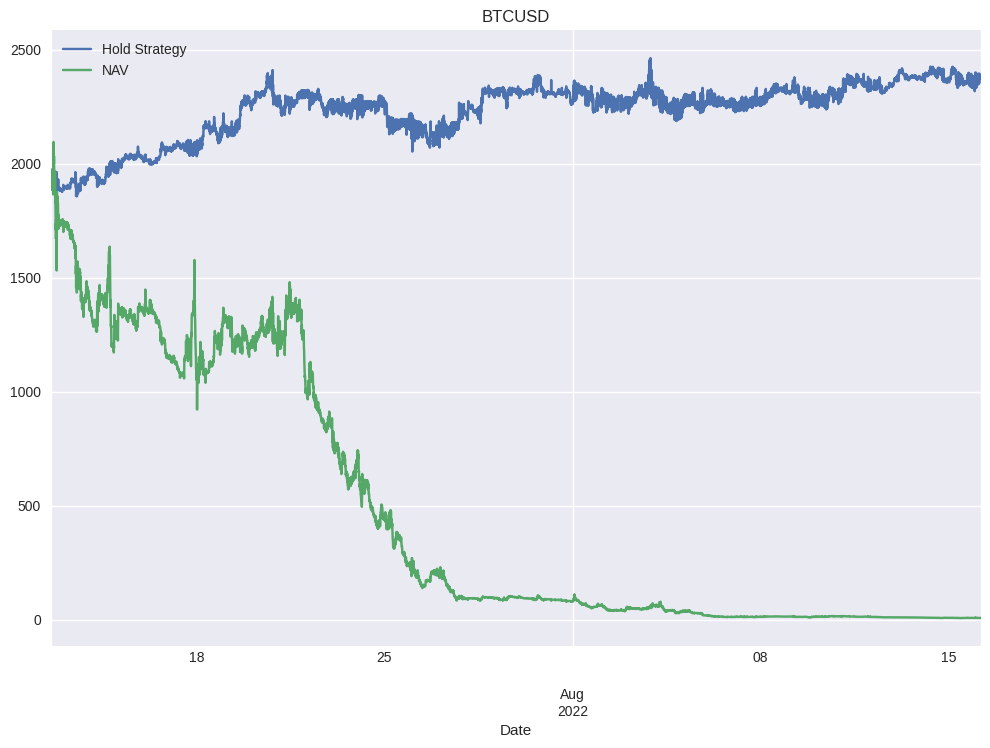

In [45]:
#plot the best strategy!
bc.plot_data(["Hold Strategy", "NAV"])

In [21]:
bc.PnLs

[-0.9848343939923485]

In [35]:
#con weights default da -14.84%
#10.97
bc.optimize_parameters(number_of_tests = 100)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2022-12-08 |  Buying 0.8441276742887285 for 17211.6, leverage 8
2022-12-08 |  Selling (closing) 0.8441276742887285 for 17230.6
2022-12-08 |  Selling 0.21179051455842102 for 17230.6, leverage 2
2022-12-08 |  Buying (closing) 0.21179051455842102 for 17234.8
2022-12-08 |  Buying 0.21131937186914468 for 17234.8, leverage 2
2022-12-08 |  Selling (closing) 0.21131937186914468 for 17260.7
2022-12-08 |  Selling 0.21128356215594077 for 17260.7, leverage 2
2022-12-08 |  Buying (closing) 0.21128356215594077 for 17262.1
2022-12-08 |  Buying 0.21091303958848226 for 17262.1, leverage 2
2022-12-08 |  Selling (closing) 0.21091303958848226 for 17286.8
2022-12-08 |  Selling 0.21086370328862203 for 17286.8, leverage 2
2022-12-08 |  Buying (closing) 0.21086370328862203 for 17256.2
2022-12-08 |  Buying 0.21162639339700226 for 17256

2022-12-09 |  Selling (closing) 0.2982737067357453 for 17221.4
2022-12-09 |  Selling 0.19847560027476066 for 17221.4, leverage 2
2022-12-09 |  Buying (closing) 0.19847560027476066 for 17217.2
2022-12-09 |  Buying 0.49519220109110196 for 17217.2, leverage 5
2022-12-09 |  Selling (closing) 0.49519220109110196 for 17202.5
2022-12-09 |  Selling 0.19692808388270075 for 17202.5, leverage 2
2022-12-09 |  Buying (closing) 0.19692808388270075 for 17202.0
2022-12-09 |  Buying 0.49102516655704725 for 17202.0, leverage 5
2022-12-09 |  Selling (closing) 0.49102516655704725 for 17200.9
2022-12-09 |  Selling 0.09796552782144484 for 17200.9, leverage 1
2022-12-09 |  Buying (closing) 0.09796552782144484 for 17207.5
2022-12-09 |  Buying 0.1955575873519279 for 17207.5, leverage 2
2022-12-09 |  Selling (closing) 0.1955575873519279 for 17219.6
2022-12-09 |  Selling 0.19538414738320198 for 17219.6, leverage 2
2022-12-09 |  Buying (closing) 0.19538414738320198 for 17205.5
2022-12-09 |  Buying 0.1955511361628

(array([0.15325332, 0.11182252, 0.85948493, 0.07866561, 0.56402082,
        0.10544879, 0.60165365]),
 1739.1)

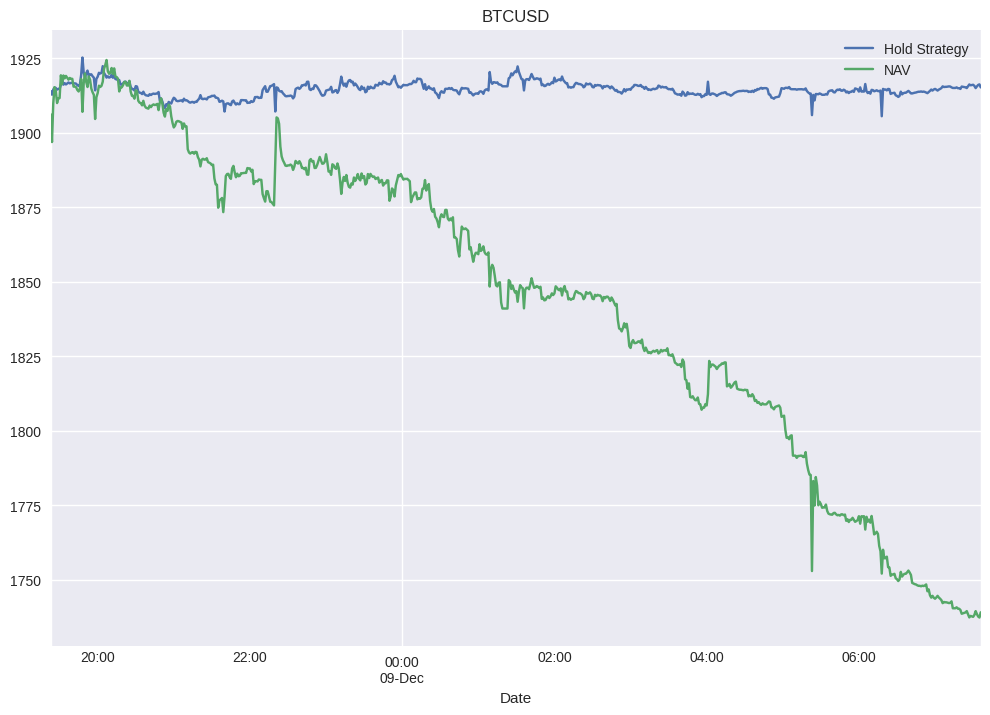

In [36]:
bc.plot_data(["Hold Strategy", "NAV"])

In [31]:
bc.data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns,Hold Strategy
Date,,,,,,,,,,,
2022-12-08 18:50:00,17220.6,17250.0,17204.1,17245.8,263.617,4.540577e+06,71,230.311,3.967085e+06,NaN,NaN
2022-12-08 18:51:00,17250.0,17250.0,17204.1,17234.0,213.698,3.685063e+06,50,41.120,7.091221e+05,-0.000684,1916.487794
2022-12-08 18:52:00,17243.1,17282.0,17234.0,17266.6,343.055,5.918446e+06,63,281.796,4.861749e+06,0.001890,1920.113041
2022-12-08 18:53:00,17270.7,17282.0,17156.0,17261.0,72.268,1.247058e+06,45,39.217,6.772184e+05,-0.000324,1919.490299
2022-12-08 18:54:00,17261.0,17264.5,17128.0,17251.6,228.176,3.932908e+06,73,58.056,1.001322e+06,-0.000545,1918.444983
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-09 07:32:00,17227.3,17229.9,17220.6,17220.6,216.794,3.734421e+06,38,73.122,1.259759e+06,-0.000389,1914.997662
2022-12-09 07:33:00,17220.7,17229.4,17220.6,17225.8,145.989,2.514298e+06,29,122.302,2.106346e+06,0.000302,1915.575922
2022-12-09 07:34:00,17222.7,17230.1,17222.7,17230.1,99.892,1.720869e+06,26,89.428,1.540650e+06,0.000250,1916.054099
